In [23]:
# !usr/env python 3.5
from load_data import Download_Video
from pretrained_model import video_classification
from datetime import datetime
import os
import h5py

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# load data
video_num = 500
frame_count = 10
video_time = 10
d = Download_Video(video_num, frame_count, video_time)
tic = datetime.now()
d.download()
toc = datetime.now()
print('Download time {0}'.format(toc-tic))

video17 url is invalid
video23 url is invalid
video34 url is invalid
video48 url is invalid
video50 url is invalid
video67 url is invalid
video70 url is invalid
video72 url is invalid
video77 url is invalid
video83 url is invalid
video91 url is invalid
video95 url is invalid
video105 url is invalid
video118 url is invalid
video121 url is invalid
video128 url is invalid
video131 url is invalid
video135 url is invalid
video144 url is invalid
video152 url is invalid
video154 url is invalid
video155 url is invalid
video170 url is invalid
video182 url is invalid
video190 url is invalid
video194 url is invalid
video196 url is invalid
video204 url is invalid
video215 url is invalid
video216 url is invalid
video228 url is invalid
video250 url is invalid
video267 url is invalid
video303 url is invalid
video311 url is invalid
video317 url is invalid
video323 url is invalid
video324 url is invalid
video332 url is invalid
video336 url is invalid
video337 url is invalid
video345 url is invalid
vide

In [3]:
tic = datetime.now()
d.preprocess()
toc = datetime.now()
print('Process time {0}'.format(toc-tic))


[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video0.mp4 -ss 137.72 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video0.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video1.mp4 -ss 184.33 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video1.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video2.mp4 -ss 31.17 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video2.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video3.mp4 -ss 48.26 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video3.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video4.mp4 -ss 268.58 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video4.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video5.mp4 -ss 0.00 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video5.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video6.mp4 -ss 143.93 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video6.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video7.mp4 -ss 81.06 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video7.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video8.mp4 -ss 0.00 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video8.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video9.mp4 -ss 0.00 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video9.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video10.mp4 -ss 33.33 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video10.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video11.mp4 -ss 81.76 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video11.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video12.mp4 -ss 73.08 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video12.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video13.mp4 -ss 682.77 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video13.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video14.mp4 -ss 81.69 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video14.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video15.mp4 -ss 158.11 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video15.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video16.mp4 -ss 268.85 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video16.mp4
... command successful.


  UserWarning)

  UserWarning)



video17 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video18.mp4 -ss 114.16 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video18.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video19.mp4 -ss 5.05 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video19.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video20.mp4 -ss 100.97 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video20.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video21.mp4 -ss 75.19 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video21.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video22.mp4 -ss 20.05 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video22.mp4
... command successful.


  UserWarning)

  UserWarning)



video23 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video24.mp4 -ss 33.51 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video24.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video25.mp4 -ss 146.43 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video25.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video26.mp4 -ss 45.89 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video26.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video27.mp4 -ss 97.92 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video27.mp4
... command successful.

[MoviePy] Running:
>>> ffmp

  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video29.mp4 -ss 147.08 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video29.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video30.mp4 -ss 260.16 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video30.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video31.mp4 -ss 186.17 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video31.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video32.mp4 -ss 28.56 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video32.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video33.mp4 -ss 122.96 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video33.mp4
... command successful.
video34 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video35.mp4 -ss 0.00 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video35.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video36.mp4 -ss 12.39 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video36.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video37.mp4 -ss 217.30 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video37.mp4
... command successful.

[MoviePy] Running:
>>> ffmp

  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video40.mp4 -ss 336.60 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video40.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video41.mp4 -ss 3.05 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video41.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video42.mp4 -ss 81.00 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video42.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video43.mp4 -ss 92.68 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video43.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun

  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video47.mp4 -ss 154.41 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video47.mp4
... command successful.
video48 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video49.mp4 -ss 52.97 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video49.mp4
... command successful.
video50 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video51.mp4 -ss 288.13 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video51.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video52.mp4 -ss 705.95 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video52.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video53.mp4 -ss 11.00 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video53.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video54.mp4 -ss 109.76 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video54.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video55.mp4 -ss 1.55 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video55.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video56.mp4 -ss 99.81 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video56.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video57.mp4 -ss 90.61 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video57.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun

  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video63.mp4 -ss 274.93 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video63.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video64.mp4 -ss 156.80 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video64.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video65.mp4 -ss 48.33 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video65.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video66.mp4 -ss 20.69 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video66.mp4
... command successful.


  UserWarning)

  UserWarning)

  UserWarning)

  UserWarning)



video67 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video68.mp4 -ss 66.49 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video68.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video69.mp4 -ss 9.64 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video69.mp4
... command successful.


  UserWarning)

  UserWarning)



video70 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video71.mp4 -ss 50.41 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video71.mp4
... command successful.
video72 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video73.mp4 -ss 1339.71 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video73.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video74.mp4 -ss 180.23 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video74.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video75.mp4 -ss 0.00 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video75.mp4
... command successful.

[Mo

  UserWarning)

  UserWarning)



video77 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video78.mp4 -ss 27.71 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video78.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video79.mp4 -ss 81.95 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video79.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video80.mp4 -ss 9.06 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video80.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video81.mp4 -ss 143.82 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video81.mp4
... command successful.

[MoviePy] Running:
>>> ffmpe

  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video88.mp4 -ss 131.60 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video88.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video89.mp4 -ss 159.21 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video89.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video90.mp4 -ss 73.20 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video90.mp4
... command successful.


  UserWarning)

  UserWarning)



video91 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video92.mp4 -ss 145.43 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video92.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video93.mp4 -ss 714.86 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video93.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video94.mp4 -ss 0.00 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video94.mp4
... command successful.
video95 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video96.mp4 -ss 116.55 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video96.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video97.mp4 -ss 125.21 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video97.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video98.mp4 -ss 358.24 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video98.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video99.mp4 -ss 31.31 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video99.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video100.mp4 -ss 1146.06 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video100.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sun

  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video107.mp4 -ss 255.34 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video107.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video108.mp4 -ss 312.53 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video108.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video109.mp4 -ss 17.29 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video109.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video110.mp4 -ss 102.94 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video110.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /hom

  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video113.mp4 -ss 166.21 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video113.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video114.mp4 -ss 83.53 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video114.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video115.mp4 -ss 358.54 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video115.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video116.mp4 -ss 80.73 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video116.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home

  UserWarning)

  UserWarning)



video128 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video129.mp4 -ss 541.05 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video129.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video130.mp4 -ss 887.53 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video130.mp4
... command successful.
video131 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video132.mp4 -ss 342.29 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video132.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video133.mp4 -ss 192.71 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video133.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video134.mp4 -ss 5.01 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video134.mp4
... command successful.
video135 url is in

  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video138.mp4 -ss 478.36 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video138.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video139.mp4 -ss 82.71 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video139.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video140.mp4 -ss 94.21 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video140.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video141.mp4 -ss 233.21 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video141.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video142.mp4 -ss 186.07 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video142.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video143.mp4 -ss 102.98 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video143.mp4
... command successful.
video144 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video145.mp4 -ss 73.27 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video145.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video146.mp4 -ss 11.88 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video146.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video147.mp4 -ss 511.73 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video147.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video148.mp4 -ss 49.58 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video148.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video149.mp4 -ss 72.62 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video149.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video150.mp4 -ss 93.30 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video150.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/

  UserWarning)

  UserWarning)



video152 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video153.mp4 -ss 206.52 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video153.mp4
... command successful.
video154 url is invalid
video155 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video156.mp4 -ss 655.94 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video156.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video157.mp4 -ss 213.61 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video157.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video158.mp4 -ss 0.00 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video158.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video159.mp4 -ss 105.99 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video159.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video160.mp4 -ss 86.72 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video160.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video161.mp4 -ss 275.20 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video161.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video162.mp4 -ss 47.63 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video162.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video163.mp4 -ss 210.88 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video163.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video164.mp4 -ss 363.01 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video164.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video165.mp4 -ss 214.58 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video165.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /hom

  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video168.mp4 -ss 4.80 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video168.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video169.mp4 -ss 47.63 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video169.mp4
... command successful.
video170 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video171.mp4 -ss 437.11 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video171.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video172.mp4 -ss 2.20 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video172.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video173.mp4 -ss 70.35 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video173.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video174.mp4 -ss 163.41 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video174.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video175.mp4 -ss 58.94 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video175.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video176.mp4 -ss 440.17 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video176.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video177.mp4 -ss 409.54 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video177.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /hom

  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video181.mp4 -ss 69.61 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video181.mp4
... command successful.
video182 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video183.mp4 -ss 23.98 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video183.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video184.mp4 -ss 21.90 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video184.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video185.mp4 -ss 22.44 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video185.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video186.mp4 -ss 50.77 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video186.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video187.mp4 -ss 380.63 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video187.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video188.mp4 -ss 163.81 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video188.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video189.mp4 -ss 325.57 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video189.mp4
... command successful.
video190 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video191.mp4 -ss 256.97 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video191.mp4
... command successful.

[MoviePy] Runni

  UserWarning)

  UserWarning)



video194 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video195.mp4 -ss 1266.45 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video195.mp4
... command successful.
video196 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video197.mp4 -ss 1406.62 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video197.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video198.mp4 -ss 44.09 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video198.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video199.mp4 -ss 0.00 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video199.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video200.mp4 -ss 445.43 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video200.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video201.mp4 -ss 129.18 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video201.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video202.mp4 -ss 318.89 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video202.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video203.mp4 -ss 24.37 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video203.mp4
... command successful.
video204 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video205.mp4 -ss 4.47 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video205.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video206.mp4 -ss 15.88 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video206.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video207.mp4 -ss 27.66 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video207.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video208.mp4 -ss 18.99 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video208.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video209.mp4 -ss 126.64 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video209.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video210.mp4 -ss 39.15 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video210.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video211.mp4 -ss 41.21 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video211.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/

  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video213.mp4 -ss 37.08 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video213.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video214.mp4 -ss 453.25 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video214.mp4
... command successful.
video215 url is invalid
video216 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video217.mp4 -ss 294.13 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video217.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video218.mp4 -ss 136.02 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video218.mp4
... command succe

  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video224.mp4 -ss 922.10 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video224.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video225.mp4 -ss 530.65 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video225.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video226.mp4 -ss 225.90 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video226.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video227.mp4 -ss 86.83 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video227.mp4
... command successful.


  UserWarning)

  UserWarning)



video228 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video229.mp4 -ss 488.85 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video229.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video230.mp4 -ss 24.27 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video230.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video231.mp4 -ss 76.87 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video231.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video232.mp4 -ss 15.36 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video232.mp4
... command successful.

[MoviePy] Running:

  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video234.mp4 -ss 275.99 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video234.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video235.mp4 -ss 135.92 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video235.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video236.mp4 -ss 81.32 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video236.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video237.mp4 -ss 142.77 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video237.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /hom

  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video240.mp4 -ss 16.41 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video240.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video241.mp4 -ss 1357.31 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video241.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video242.mp4 -ss 54.25 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video242.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video243.mp4 -ss 43.78 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video243.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video244.mp4 -ss 157.48 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video244.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video245.mp4 -ss 138.17 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video245.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video246.mp4 -ss 54.84 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video246.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video247.mp4 -ss 37.33 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video247.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video248.mp4 -ss 36.82 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video248.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video249.mp4 -ss 164.01 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video249.mp4
... command successful.
video250 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video251.mp4 -ss 51.81 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video251.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video252.mp4 -ss 399.85 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video252.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video253.mp4 -ss 19.63 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video253.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video254.mp4 -ss 137.99 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video254.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video255.mp4 -ss 0.00 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video255.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video256.mp4 -ss 522.45 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video256.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video257.mp4 -ss 13.85 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video257.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video258.mp4 -ss 206.05 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video258.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video259.mp4 -ss 19.85 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video259.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video260.mp4 -ss 601.25 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video260.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video261.mp4 -ss 50.60 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video261.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video262.mp4 -ss 598.48 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video262.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video263.mp4 -ss 34.92 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video263.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video264.mp4 -ss 291.64 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video264.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video265.mp4 -ss 71.05 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video265.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video266.mp4 -ss 388.37 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video266.mp4
... command successful.
video267 url is invalid

[MoviePy] Running

  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video275.mp4 -ss 276.93 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video275.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video276.mp4 -ss 80.75 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video276.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video277.mp4 -ss 131.21 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video277.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video278.mp4 -ss 523.42 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video278.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video279.mp4 -ss 238.09 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video279.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video280.mp4 -ss 24.70 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video280.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /hom

  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video282.mp4 -ss 546.05 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video282.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video283.mp4 -ss 537.45 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video283.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video284.mp4 -ss 68.41 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video284.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video285.mp4 -ss 53.39 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video285.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video286.mp4 -ss 6.75 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video286.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video287.mp4 -ss 142.06 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video287.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video288.mp4 -ss 118.07 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video288.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video289.mp4 -ss 20.99 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video289.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video290.mp4 -ss 215.16 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video290.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /hom

  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video294.mp4 -ss 23.36 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video294.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video295.mp4 -ss 82.06 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video295.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video296.mp4 -ss 25.05 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video296.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video297.mp4 -ss 94.34 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video297.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video298.mp4 -ss 163.01 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video298.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/

  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video301.mp4 -ss 168.32 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video301.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video302.mp4 -ss 220.90 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video302.mp4
... command successful.
video303 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video304.mp4 -ss 126.69 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video304.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video305.mp4 -ss 501.57 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video305.mp4
... command successful.

[MoviePy] Runni

  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video309.mp4 -ss 114.92 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video309.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video310.mp4 -ss 345.76 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video310.mp4
... command successful.
video311 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video312.mp4 -ss 8.13 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video312.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video313.mp4 -ss 2320.10 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video313.mp4
... command successful.

[MoviePy] Runnin

  UserWarning)

  UserWarning)



video317 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video318.mp4 -ss 28.69 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video318.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video319.mp4 -ss 494.93 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video319.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video320.mp4 -ss 60.93 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video320.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video321.mp4 -ss 112.86 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video321.mp4
... command successful.

[MoviePy] Running

  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video326.mp4 -ss 114.78 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video326.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video327.mp4 -ss 32.05 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video327.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video328.mp4 -ss 169.77 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video328.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video329.mp4 -ss 141.09 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video329.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video330.mp4 -ss 109.25 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video330.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /hom

  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video340.mp4 -ss 157.41 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video340.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video341.mp4 -ss 74.86 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video341.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video342.mp4 -ss 989.62 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video342.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video343.mp4 -ss 985.80 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video343.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video344.mp4 -ss 138.49 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video344.mp4
... command successful.
video345 url is invalid

[MoviePy] Runnin

  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video350.mp4 -ss 921.11 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video350.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video351.mp4 -ss 337.59 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video351.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video352.mp4 -ss 49.30 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video352.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video353.mp4 -ss 760.56 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video353.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /hom

  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video375.mp4 -ss 61.78 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video375.mp4
... command successful.
video376 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video377.mp4 -ss 10.49 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video377.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video378.mp4 -ss 8.05 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video378.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video379.mp4 -ss 44.49 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video379.mp4
... command successful.

[MoviePy] Running:
>

  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video383.mp4 -ss 282.28 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video383.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video384.mp4 -ss 57.23 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video384.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video385.mp4 -ss 3.20 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video385.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video386.mp4 -ss 39.84 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video386.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video387.mp4 -ss 116.00 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video387.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video388.mp4 -ss 125.42 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video388.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video389.mp4 -ss 317.37 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video389.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /hom

  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video392.mp4 -ss 382.60 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video392.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video393.mp4 -ss 4.68 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video393.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video394.mp4 -ss 549.05 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video394.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video395.mp4 -ss 71.57 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video395.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video396.mp4 -ss 79.41 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video396.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video397.mp4 -ss 185.82 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video397.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video398.mp4 -ss 0.00 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video398.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/s

  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video402.mp4 -ss 251.21 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video402.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video403.mp4 -ss 556.98 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video403.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video404.mp4 -ss 44.17 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video404.mp4
... command successful.
video405 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video406.mp4 -ss 130.68 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video406.mp4
... command successful.

[MoviePy] Runnin

  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video412.mp4 -ss 305.02 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video412.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video413.mp4 -ss 3.05 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video413.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video414.mp4 -ss 53.77 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video414.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video415.mp4 -ss 9.69 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video415.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video416.mp4 -ss 204.18 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video416.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video417.mp4 -ss 30.41 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video417.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video418.mp4 -ss 132.60 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video418.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video419.mp4 -ss 90.44 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video419.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video420.mp4 -ss 61.81 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video420.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video421.mp4 -ss 113.99 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video421.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video422.mp4 -ss 100.61 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video422.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home

  UserWarning)

  UserWarning)



video427 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video428.mp4 -ss 41.05 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video428.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video429.mp4 -ss 925.77 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video429.mp4
... command successful.
video430 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video431.mp4 -ss 167.93 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video431.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video432.mp4 -ss 115.69 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video432.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video433.mp4 -ss 346.76 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video433.mp4
... command successful.
video434 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video435.mp4 -ss 29.24 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video435.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video436.mp4 -ss 48.72 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video436.mp4
... command successful.


  UserWarning)

  UserWarning)



video437 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video438.mp4 -ss 173.89 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video438.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video439.mp4 -ss 187.57 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video439.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video440.mp4 -ss 16.06 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video440.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video441.mp4 -ss 351.16 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video441.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video442.mp4 -ss 279.95 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video442.mp4
... command successful.
video443 url is invalid
video444 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video445.mp4 -ss 135.32 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video445.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video446.mp4 -ss 415.69 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video446.mp4
... command successful.
video447 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video448.mp4 -ss 108.76 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video

  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video451.mp4 -ss 57.20 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video451.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video452.mp4 -ss 198.87 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video452.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video453.mp4 -ss 158.35 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video453.mp4
... command successful.


  UserWarning)

  UserWarning)



video454 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video455.mp4 -ss 69.05 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video455.mp4
... command successful.
video456 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video457.mp4 -ss 10.02 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video457.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video458.mp4 -ss 118.82 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video458.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video459.mp4 -ss 1583.95 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video459.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video460.mp4 -ss 0.00 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video460.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video461.mp4 -ss 142.69 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video461.mp4
... command successful.
video462 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video463.mp4 -ss 1453.37 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video463.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video464.mp4 -ss 274.39 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video464.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video465.mp4 -ss 108.48 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video465.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video466.mp4 -ss 418.67 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video466.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video467.mp4 -ss 60.40 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video467.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video468.mp4 -ss 86.68 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video468.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video469.mp4 -ss 24.73 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video469.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video470.mp4 -ss 206.34 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video470.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video471.mp4 -ss 1085.20 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video471.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video472.mp4 -ss 5.75 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video472.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video473.mp4 -ss 73.62 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video473.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video474.mp4 -ss 303.75 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video474.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home

  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video476.mp4 -ss 1175.77 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video476.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video477.mp4 -ss 250.28 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video477.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video478.mp4 -ss 225.88 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video478.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video479.mp4 -ss 212.28 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video479.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video480.mp4 -ss 46.33 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video480.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video481.mp4 -ss 249.83 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video481.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /hom

  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video483.mp4 -ss 410.06 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video483.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video484.mp4 -ss 133.25 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video484.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video485.mp4 -ss 77.83 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video485.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video486.mp4 -ss 620.13 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video486.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video487.mp4 -ss 571.95 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video487.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video488.mp4 -ss 205.64 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video488.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video489.mp4 -ss 0.00 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video489.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video490.mp4 -ss 17.60 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video490.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video491.mp4 -ss 1351.73 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video491.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video492.mp4 -ss 51.13 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video492.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video493.mp4 -ss 1079.38 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video493.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video494.mp4 -ss 75.53 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video494.mp4
... command successful.
video495 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video496.mp4 -ss 43.11 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video496.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video497.mp4 -ss 151.37 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video497.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video498.mp4 -ss 39.01 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video498.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video499.mp4 -ss 30.69 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video499.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video500.mp4 -ss 27.26 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video500.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/

  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video503.mp4 -ss 128.73 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video503.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video504.mp4 -ss 259.38 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video504.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video505.mp4 -ss 19.23 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video505.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video506.mp4 -ss 1840.69 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video506.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video507.mp4 -ss 1331.81 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video507.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video508.mp4 -ss 8.31 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video508.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /hom

  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video513.mp4 -ss 360.61 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video513.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video514.mp4 -ss 46.28 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video514.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video515.mp4 -ss 3.34 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video515.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video516.mp4 -ss 54.37 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video516.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/s

  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video518.mp4 -ss 91.85 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video518.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video519.mp4 -ss 389.76 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video519.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video520.mp4 -ss 156.47 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video520.mp4
... command successful.
video521 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video522.mp4 -ss 135.85 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video522.mp4
... command successful.

[MoviePy] Runnin

  UserWarning)

  UserWarning)



video534 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video535.mp4 -ss 260.77 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video535.mp4
... command successful.


  UserWarning)

  UserWarning)



video536 url is invalid
video537 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video538.mp4 -ss 221.20 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video538.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video539.mp4 -ss 169.02 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video539.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video540.mp4 -ss 519.17 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video540.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video541.mp4 -ss 108.41 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video541.mp4
... command succ

  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video543.mp4 -ss 167.45 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video543.mp4
... command successful.
video544 url is invalid
video545 url is invalid

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video546.mp4 -ss 126.13 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video546.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video547.mp4 -ss 143.49 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video547.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video548.mp4 -ss 20.92 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video548.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video549.mp4 -ss 13.13 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video549.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video550.mp4 -ss 40.59 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video550.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video551.mp4 -ss 73.29 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video551.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video552.mp4 -ss 666.42 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video552.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video553.mp4 -ss 232.28 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video553.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video554.mp4 -ss 106.77 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video554.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video555.mp4 -ss 0.00 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video555.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video556.mp4 -ss 722.01 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video556.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video557.mp4 -ss 104.48 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video557.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video558.mp4 -ss 657.37 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video558.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video559.mp4 -ss 150.73 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video559.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video560.mp4 -ss 29.90 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video560.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video561.mp4 -ss 81.43 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video561.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video562.mp4 -ss 601.69 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video562.mp4
... command successful.

[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video563.mp4 -ss 101.94 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video563.mp4
... command successful.


  UserWarning)

  UserWarning)




[MoviePy] Running:
>>> ffmpeg -y -i /home/sunjiajun/cs231n_project/datasets/videos/video564.mp4 -ss 789.29 -t 10.00 -vcodec copy -acodec copy /home/sunjiajun/cs231n_project/datasets/processed/processed_video564.mp4
... command successful.
Finish preprocess all videos
Process time 0:09:42.413916


In [15]:
# model
model = video_classification()
curr_path = os.getcwd()
frame_dir = curr_path + '/datasets/frames'
num_videos = 500
tic = datetime.now()
features = model.load_features(frame_dir, num_videos)
toc = datetime.now()
print('Feature fusion time: ', toc-tic)

Feature fusion time:  0:02:43.906579


In [16]:
# check
import numpy as np
y = np.load(curr_path+'/datasets/category.npy')
y = y[:num_videos]
print(y.shape)
print(features.shape)
print(y)

(500,)
(500, 10, 7, 7, 512)
[ 9 16  9  8 14 13 13 17  3  5  6 13  7  3  7 12  2  1  3 19  3 16 10  9  6
  0  3  3  4  3 19 18 16 10 18 14 13  6  4  9  0  3  3 10  0  3 19 13 14  2
  7  0 14 12 18  3 10 18  3  9 14  0 16  6  8  4  2 17 17  6 12 12  7  3  7
 18  9  8 16 17 13 13  3  1 10  0 18  3 12  7 12 16  7  0 11 17  8  7  4 11
  4  3  9  4 12  0  9  3 16 14  9 18  0 10  7 18 14 11  3 12  2 13  9  7  7
 10  9  7 17  2  9  3  7 16  7  3  3 13 13  6 14  6  3 13  7  7 11 12  9 19
 16 14  7  5 19 13  7  2 11  3 13  0 13  2 12  9 10 17 18 13 13 12  7  2 13
 16 15  3  1  0 10 10 18 12 14  4 16  7  8 12  6  1 16  7  2 16  1  0  2  9
  5  2  4 17  4  5  0  4 14  4 13  7  9 11  7  7  3 12  6  9  3 17  3  9  2
 19 10  9  3  4  2 14  3 12  3 17  2 12  3  7  4 16 10  4  3  5  3 14  7 13
  5  5 16  8  3  8  7 12  2  3 17  2 12  9 17 18 14 12 13  3 14 13  9 16  2
  7 13  9  7 18 16 19 16 18  2 16  4  0  0 13  1  0 14  7  7 12 15 12 11  6
  3  0  3  0  7  3 16  9  2 10  0 14  1  7 14 13  0  7  9 14

Model is Training...
dict_keys(['loss', 'val_loss', 'val_acc', 'acc'])


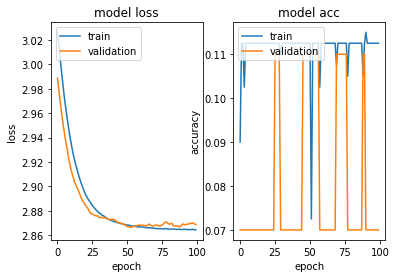

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
hist = model.train(features, y, lr = 1e-3)
print(hist.history.keys())

# summarize history for accuracy
plt.subplot(121)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.subplot(122)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [25]:
model.predict(features, y)

Video Classification Accuracy: 0.104


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


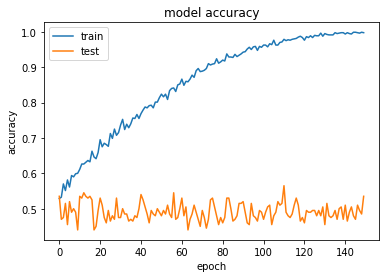

In [11]:
# test model train example

from keras.models import Sequential
from keras.layers import Dense, Activation
import matplotlib.pyplot as plt
%matplotlib inline

m = Sequential()
m.add(Dense(32, activation='relu', input_dim=100))
m.add(Dense(1, activation='sigmoid'))
m.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Generate dummy data
import numpy as np
data = np.random.random((1000, 100))
labels = np.random.randint(2, size=(1000, 1))

# Train the model, iterating on the data in batches of 32 samples
history = m.fit(data, labels, epochs=150, batch_size=32, validation_split = 0.2, verbose = 0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
from keras.utils import to_categorical